# Задание 1 - `Предобработка данных`

## Импорт библиотек и зависимостей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    precision_recall_curve, roc_curve, auc, RocCurveDisplay
)

## Загрузка и предпроцессинг датасета 
#### Удаление строк с пропусками, нечисловых столбцов, перевод данных в числовой вид

In [2]:
df = pd.read_csv('Titanic.csv')

initial_rows = df.shape[0]
initial_columns = df.shape[1]
df_cleaned = df.dropna()

non_numeric_cols = []
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object' and col not in ['Sex', 'Embarked']:
        non_numeric_cols.append(col)

df_cleaned = df_cleaned.drop(columns=non_numeric_cols)

df_cleaned['Sex'] = df_cleaned['Sex'].map({'male': 0, 'female': 1})

df_cleaned['Embarked'] = df_cleaned['Embarked'].fillna('S')
port_mapping = {'C': 1, 'S': 2, 'Q': 3}
df_cleaned['Embarked'] = df_cleaned['Embarked'].map(port_mapping)

if 'PassengerId' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['PassengerId'])

## Вычисление % потерянных данных

In [3]:
rows_lost = initial_rows - df_cleaned.shape[0]
cols_lost = initial_columns - df_cleaned.shape[1]

print(f"Потеряно строк: {rows_lost} из {initial_rows}")
print(f"Потеряно столбцов: {cols_lost} из {initial_columns}")

Потеряно строк: 708 из 891
Потеряно столбцов: 4 из 12


---

# Задание 2 - `Машинное обучение`

## Разделение данных на обучающую и тестовую выборки

In [4]:
X = df_cleaned.drop('Survived', axis=1)
y = df_cleaned['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (128, 7)
Размер тестовой выборки: (55, 7)


## Обучение модели логистической регрессии

In [5]:
model_with_embarked = LogisticRegression(random_state=42, max_iter=1000)
model_with_embarked.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

## Предсказания и оценка

In [6]:
y_pred_with = model_with_embarked.predict(X_test)
y_pred_proba_with = model_with_embarked.predict_proba(X_test)[:, 1]
accuracy_with = accuracy_score(y_test, y_pred_with)

print(f"Точность модели с признаком Embarked: {accuracy_with:.4f}")
print(f"Точность на обучающей выборке: {model_with_embarked.score(X_train, y_train):.4f}")

Точность модели с признаком Embarked: 0.7636
Точность на обучающей выборке: 0.7891


## Создание копии данных без признака Embarked

In [7]:
X_without_embarked = X.drop('Embarked', axis=1)

## Разделение данных, обучение и оценка модели без Embarked

In [8]:
X_train_wo, X_test_wo, y_train_wo, y_test_wo = train_test_split(
    X_without_embarked, y, test_size=0.3, random_state=42, stratify=y
)
model_without_embarked = LogisticRegression(random_state=42, max_iter=1000)
model_without_embarked.fit(X_train_wo, y_train_wo)

y_pred_without = model_without_embarked.predict(X_test_wo)
accuracy_without = accuracy_score(y_test_wo, y_pred_without)

print(f"Точность модели с признаком Embarked:    {accuracy_with:.4f}")
print(f"Точность модели без признака Embarked:   {accuracy_without:.4f}")
print(f"Разница в точности: {abs(accuracy_with - accuracy_without):.4f}")

Точность модели с признаком Embarked:    0.7636
Точность модели без признака Embarked:   0.7455
Разница в точности: 0.0182


---

# Задание 3 - `Расчёт метрик классификации`

## Расчёт метрик

In [9]:
precision = precision_score(y_test, y_pred_with)
recall = recall_score(y_test, y_pred_with)
f1 = f1_score(y_test, y_pred_with)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {accuracy_with:.4f}")

Precision: 0.8158
Recall:    0.8378
F1-score:  0.8267
Accuracy:  0.7636


## Построение матрицы ошибок

In [10]:
cm = confusion_matrix(y_test, y_pred_with)
print("Матрица ошибок:")
print(cm)

Матрица ошибок:
[[11  7]
 [ 6 31]]


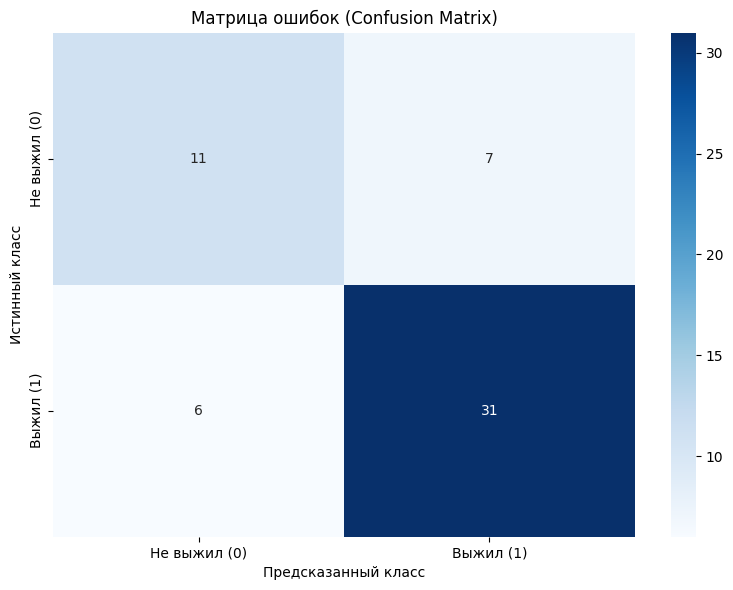

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не выжил (0)', 'Выжил (1)'],
            yticklabels=['Не выжил (0)', 'Выжил (1)'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

## Кривая Precision-Recall

In [12]:
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_with)
pr_auc = auc(recall_vals, precision_vals)

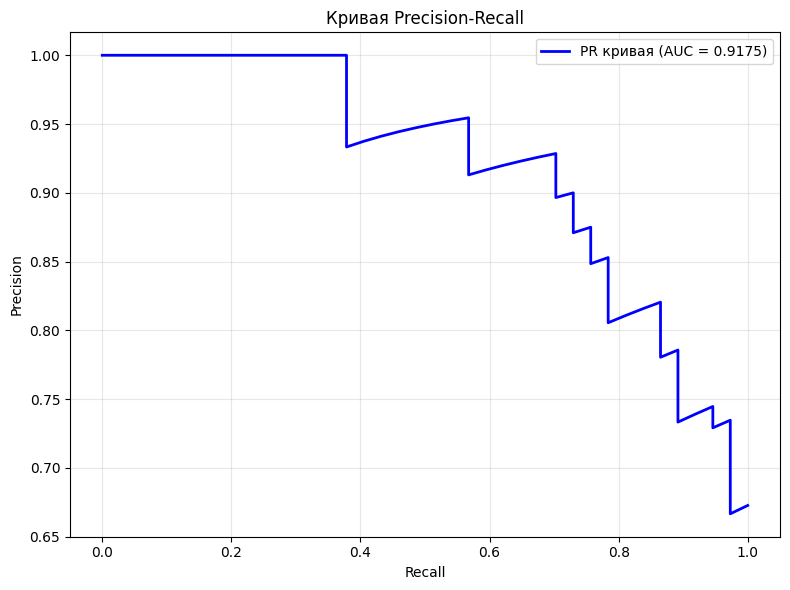

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2,
         label=f'PR кривая (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Кривая ROC   

In [14]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_with)
roc_auc = auc(fpr, tpr)

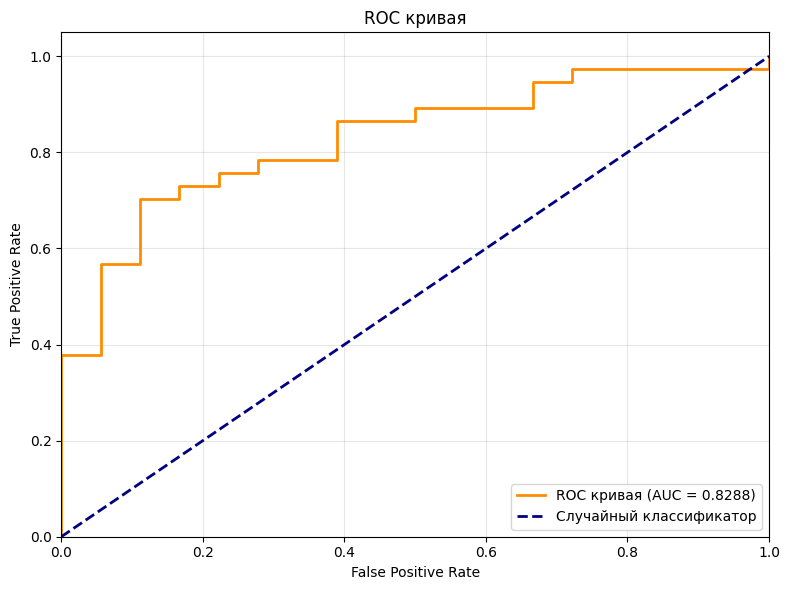

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Вывод

In [32]:
print("""
Основные метрики:
   - Accuracy (точность): {:.4f} - модель правильно классифицирует {:.1f}% пассажиров
   - Precision: {:.4f} - из всех предсказанных выживших действительно выжило {:.1f}%
   - Recall: {:.4f} - модель нашла {:.1f}% всех реально выживших пассажиров
   - F1-score: {:.4f} - среднее между precision и recall
""".format(
    accuracy_with, accuracy_with*100,
    precision, precision*100,
    recall, recall*100,
    f1
))


Основные метрики:
   - Accuracy (точность): 0.7636 - модель правильно классифицирует 76.4% пассажиров
   - Precision: 0.8158 - из всех предсказанных выживших действительно выжило 81.6%
   - Recall: 0.8378 - модель нашла 83.8% всех реально выживших пассажиров
   - F1-score: 0.8267 - среднее между precision и recall



---

# Задание 4

## Масштабирование для SVM и KNN

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_with_embarked_scaled = LogisticRegression(random_state=42, max_iter=1000)
model_with_embarked_scaled.fit(X_train_scaled, y_train)
y_pred_log_reg_scaled = model_with_embarked_scaled.predict(X_test_scaled)

## Модель опорных векторов (SVM)

In [18]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


## Предсказания для SVM

In [19]:
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

## Модель ближайших соседей (KNN)

In [20]:
k_values = range(1, 21)
cv_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Оптимальное количество соседей: {optimal_k}")

Оптимальное количество соседей: 18


## Обучение KNN с оптимальным k + предсказания

In [21]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

---

## Функция для расчета и отображения метрик

In [22]:
def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"  ROC-AUC:   {roc_auc:.4f}")

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if y_pred_proba is not None else None,
        'confusion_matrix': cm
    }

# Оценка всех моделей

In [23]:
results = []

results.append(evaluate_model(
    "Логистическая регрессия",
    y_test, y_pred_log_reg_scaled,
    model_with_embarked_scaled.predict_proba(X_test_scaled)[:, 1]
))
results.append(evaluate_model(
    "Метод опорных векторов (SVM)",
    y_test, y_pred_svm,
    y_pred_proba_svm
))
results.append(evaluate_model(
    f"K-ближайших соседей (K={optimal_k})",
    y_test, y_pred_knn,
    y_pred_proba_knn
))
results_df = pd.DataFrame(results)


Логистическая регрессия:
  Accuracy:  0.7273
  Precision: 0.8056
  Recall:    0.7838
  F1-score:  0.7945
  ROC-AUC:   0.8303

Метод опорных векторов (SVM):
  Accuracy:  0.7091
  Precision: 0.7692
  Recall:    0.8108
  F1-score:  0.7895
  ROC-AUC:   0.8198

K-ближайших соседей (K=18):
  Accuracy:  0.7818
  Precision: 0.8571
  Recall:    0.8108
  F1-score:  0.8333
  ROC-AUC:   0.8093


## Вывод

In [24]:
comparison_df = results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
print("\nСравнительная таблица метрик:")
print(comparison_df.to_string(index=False))


Сравнительная таблица метрик:
                       model  accuracy  precision   recall       f1  roc_auc
     Логистическая регрессия  0.727273   0.805556 0.783784 0.794521 0.830330
Метод опорных векторов (SVM)  0.709091   0.769231 0.810811 0.789474 0.819820
  K-ближайших соседей (K=18)  0.781818   0.857143 0.810811 0.833333 0.809309


## График сравнения метрик

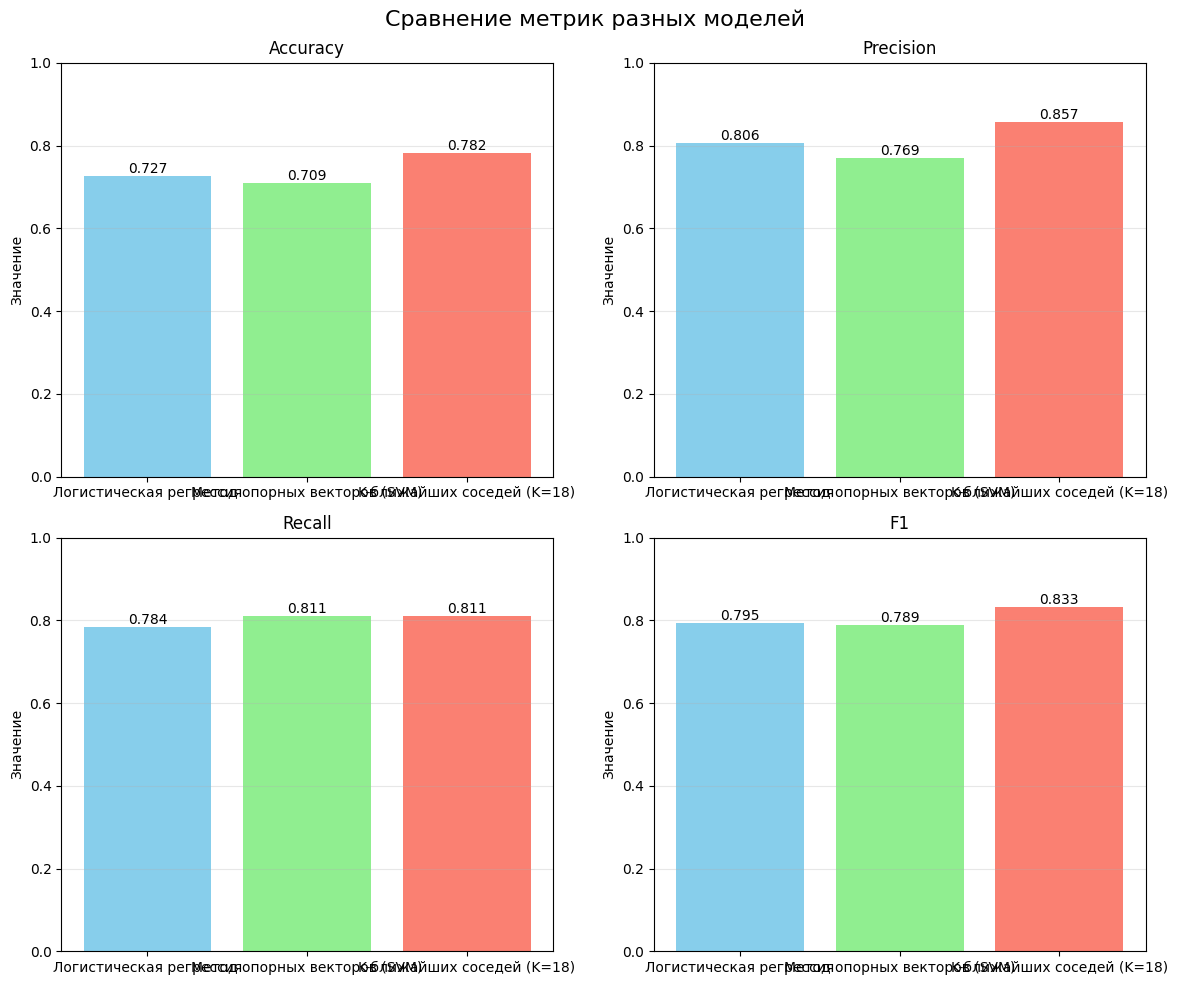

In [25]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Сравнение метрик разных моделей', fontsize=16)

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    models = results_df['model']
    values = results_df[metric]

    bars = ax.bar(models, values, color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_title(f'{metric.capitalize()}')
    ax.set_ylabel('Значение')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## ROC-кривые для моделей

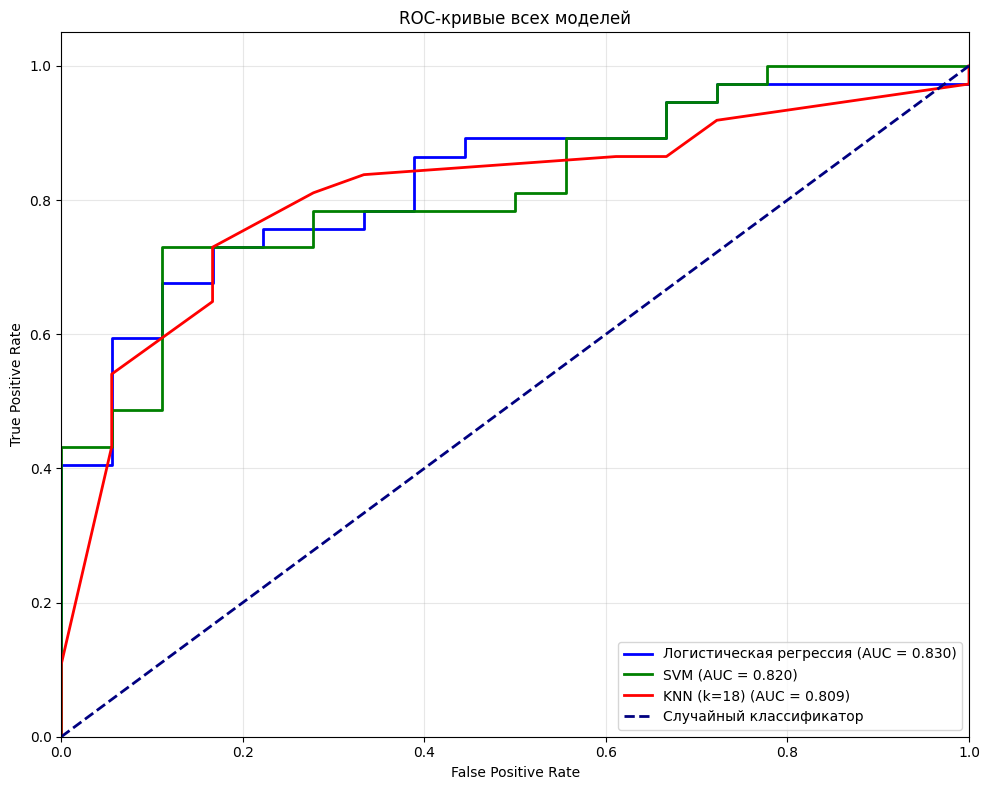

In [26]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']

models_info = [
    ("Логистическая регрессия", model_with_embarked_scaled, X_test_scaled, 'blue'),
    ("SVM", svm_model, X_test_scaled, 'green'),
    (f"KNN (k={optimal_k})", knn_model, X_test_scaled, 'red')
]

for name, model, X_test_data, color in models_info:
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_data)[:, 1]
    else:
        y_proba = model.decision_function(X_test_data)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые всех моделей')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Матрицы ошибок для моделей

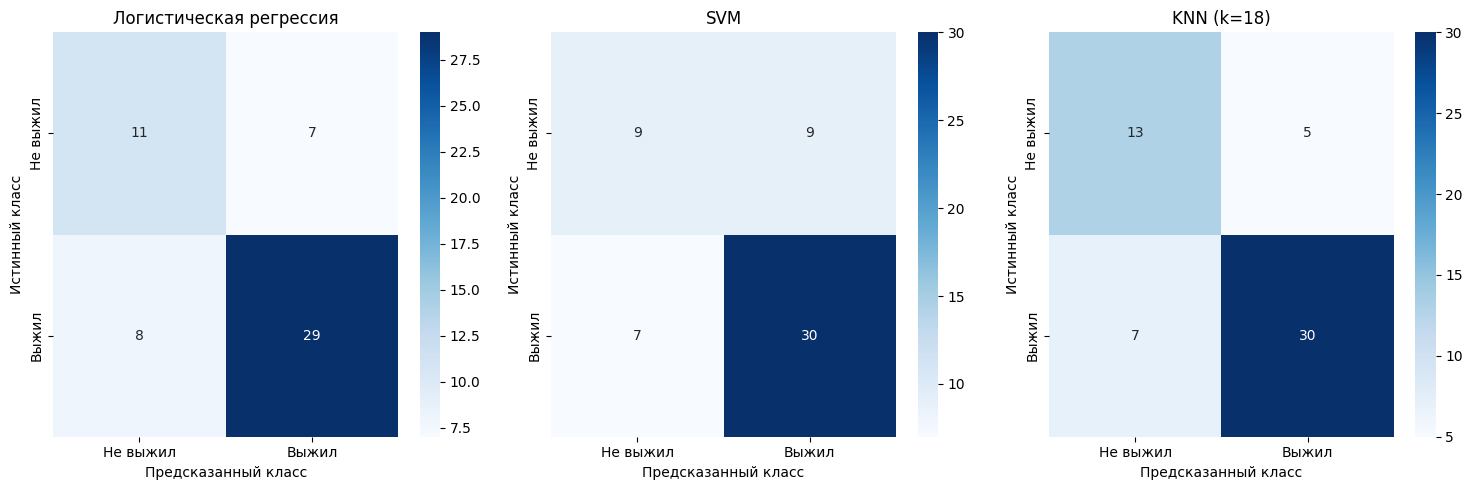

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
model_names = ["Логистическая регрессия", "SVM", f"KNN (k={optimal_k})"]
predictions = [y_pred_log_reg_scaled, y_pred_svm, y_pred_knn]

for idx, (ax, name, y_pred) in enumerate(zip(axes, model_names, predictions)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Не выжил', 'Выжил'],
                yticklabels=['Не выжил', 'Выжил'])
    ax.set_title(name)
    ax.set_ylabel('Истинный класс')
    ax.set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()

---

# Анализ

In [28]:
print("\nЛучшие модели по метрикам:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    if metric in results_df.columns:
        best_idx = results_df[metric].idxmax()
        best_model = results_df.loc[best_idx, 'model']
        best_value = results_df.loc[best_idx, metric]
        print(f"  {metric.upper():<12} : {best_model:<30} ({best_value:.4f})")


Лучшие модели по метрикам:
  ACCURACY     : K-ближайших соседей (K=18)     (0.7818)
  PRECISION    : K-ближайших соседей (K=18)     (0.8571)
  RECALL       : Метод опорных векторов (SVM)   (0.8108)
  F1           : K-ближайших соседей (K=18)     (0.8333)
  ROC_AUC      : Логистическая регрессия        (0.8303)


In [33]:
best_overall_idx = results_df['f1'].idxmax()
best_model_overall = results_df.loc[best_overall_idx, 'model']
best_f1 = results_df.loc[best_overall_idx, 'f1']

print(f"Лучшая модель (по F1-score): {best_model_overall}")
print(f"F1-score: {best_f1:.4f}")

Лучшая модель (по F1-score): K-ближайших соседей (K=18)
F1-score: 0.8333


## Сравнительный анализ

In [34]:
log_reg_metrics = results_df[results_df['model'] == "Логистическая регрессия"].iloc[0]
svm_metrics = results_df[results_df['model'] == "Метод опорных векторов (SVM)"].iloc[0]
knn_metrics = results_df[results_df['model'].str.contains("K-ближайших соседей")].iloc[0]

print(f"\n1. Логистическая регрессия:")
print(f"   • Преимущества: Простота интерпретации, быстрая обучение")
print(f"   • Недостатки: Линейность ограничивает сложные зависимости")
print(f"   • Лучшая метрика: Precision = {log_reg_metrics['precision']:.4f}")

print(f"\n2. Метод опорных векторов (SVM):")
print(f"   • Преимущества: Эффективен в высокоразмерных пространствах")
print(f"   • Недостатки: Медленное обучение на больших выборках")
print(f"   • Лучшая метрика: Recall = {svm_metrics['recall']:.4f}")

print(f"\n3. K-ближайших соседей (K={optimal_k}):")
print(f"   • Преимущества: Простота, не требует обучения")
print(f"   • Недостатки: Чувствителен к выбросам, медленный при предсказании")
print(f"   • Лучшая метрика: F1-score = {knn_metrics['f1']:.4f}")


1. Логистическая регрессия:
   • Преимущества: Простота интерпретации, быстрая обучение
   • Недостатки: Линейность ограничивает сложные зависимости
   • Лучшая метрика: Precision = 0.8056

2. Метод опорных векторов (SVM):
   • Преимущества: Эффективен в высокоразмерных пространствах
   • Недостатки: Медленное обучение на больших выборках
   • Лучшая метрика: Recall = 0.8108

3. K-ближайших соседей (K=18):
   • Преимущества: Простота, не требует обучения
   • Недостатки: Чувствителен к выбросам, медленный при предсказании
   • Лучшая метрика: F1-score = 0.8333
